In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


# Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec
import re
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK 

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Load the dataset

In [4]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Basic EDA

In [5]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample Data:")
display(df.head())

Dataset Shape: (50000, 2)

Columns: ['review', 'sentiment']

Sample Data:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Text preprocessing function

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing

In [7]:
print("Preprocessing reviews...")
df['processed_review'] = df['review'].apply(preprocess_text)

Preprocessing reviews...


# 1. Total words and vocabulary

In [8]:
def get_corpus_stats(texts):
    all_words = ' '.join(texts).split()
    vocabulary = set(all_words)
    return len(all_words), len(vocabulary)

total_words, vocab_size = get_corpus_stats(df['processed_review'])
print(f"\nTotal words in corpus: {total_words}")
print(f"Vocabulary size: {vocab_size}")


Total words in corpus: 5933131
Vocabulary size: 215412


# 2. One Hot Encoding (for demonstration, using first 1000 most common words)

In [9]:
def create_one_hot_encoding(texts, max_features=1000):
    vectorizer = CountVectorizer(max_features=max_features, binary=True)
    one_hot = vectorizer.fit_transform(texts)
    return one_hot, vectorizer.get_feature_names_out()

one_hot_matrix, one_hot_features = create_one_hot_encoding(df['processed_review'])
print(f"\nOne-hot encoding shape: {one_hot_matrix.shape}")


One-hot encoding shape: (50000, 1000)


# 3. Bag of Words

In [10]:
def create_bow(texts, max_features=5000):
    vectorizer = CountVectorizer(max_features=max_features)
    bow = vectorizer.fit_transform(texts)
    
    # Get word frequencies
    word_freq = pd.DataFrame(
        bow.sum(axis=0).T,
        index=vectorizer.get_feature_names_out(),
        columns=['frequency']
    ).sort_values('frequency', ascending=False)
    
    return bow, word_freq

bow_matrix, word_frequencies = create_bow(df['processed_review'])
print("\nTop 10 most frequent words:")
print(word_frequencies.head(10))


Top 10 most frequent words:
        frequency
movie       83585
film        74530
one         50399
like        38838
good        28502
even        24289
would       24001
time        23302
really      22900
see         22439


# 4. N-grams

In [11]:
def create_ngrams(texts, n, max_features=5000):
    vectorizer = CountVectorizer(ngram_range=(n,n), max_features=max_features)
    ngrams = vectorizer.fit_transform(texts)
    return ngrams, len(vectorizer.get_feature_names_out())

bigram_matrix, bigram_vocab_size = create_ngrams(df['processed_review'], 2)
trigram_matrix, trigram_vocab_size = create_ngrams(df['processed_review'], 3)

print(f"\nBigram vocabulary size: {bigram_vocab_size}")
print(f"Trigram vocabulary size: {trigram_vocab_size}")


Bigram vocabulary size: 5000
Trigram vocabulary size: 5000


# 5. TF-IDF

In [12]:
def analyze_tfidf(texts, max_features=5000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    
    # Calculate IDF scores
    idf_scores = pd.DataFrame(
        {'term': tfidf_vectorizer.get_feature_names_out(),
         'idf_score': tfidf_vectorizer.idf_}
    ).sort_values('idf_score', ascending=False)
    
    return tfidf_matrix, idf_scores

tfidf_matrix, idf_scores = analyze_tfidf(df['processed_review'])
print("\nTop 10 words by IDF score:")
print(idf_scores.head(10))


Top 10 words by IDF score:
           term  idf_score
1056     custer   8.106226
711         che   8.082129
1834      garbo   7.887973
4223  streisand   7.849506
487      bourne   7.676664
2717      marty   7.645411
2905     muppet   7.600291
1836   garfield   7.557118
230     argento   7.543132
2407    karloff   7.529339


# 6. Additional EDA

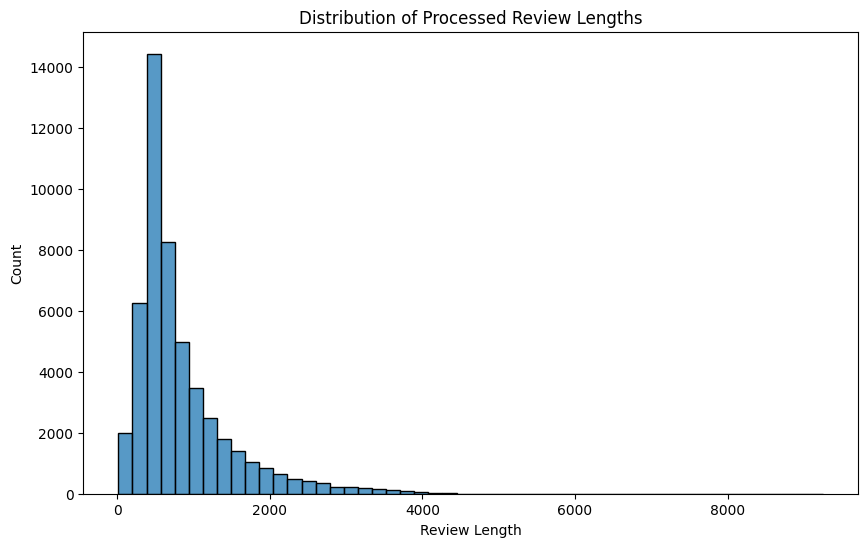

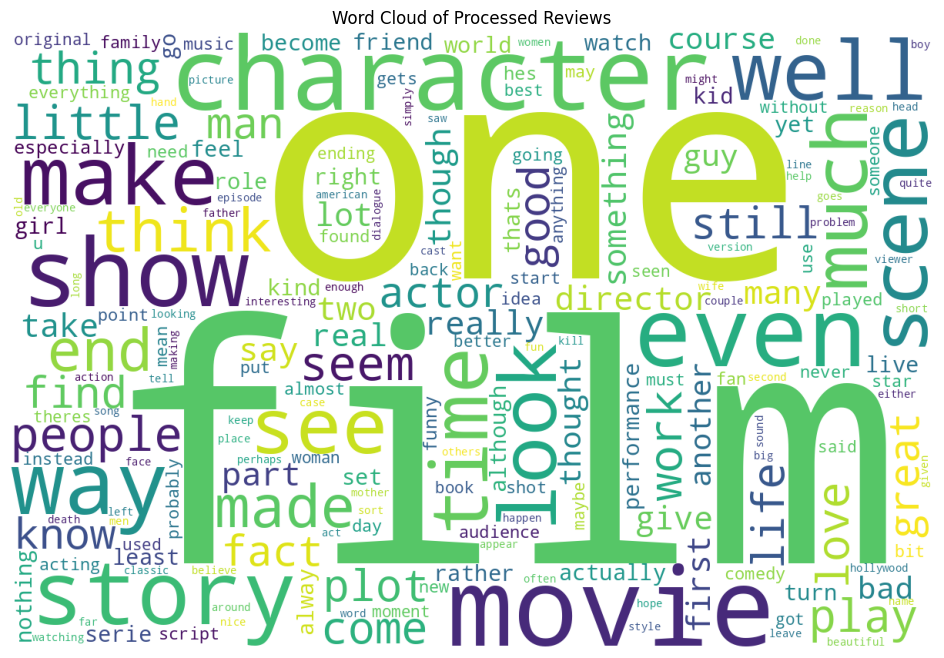

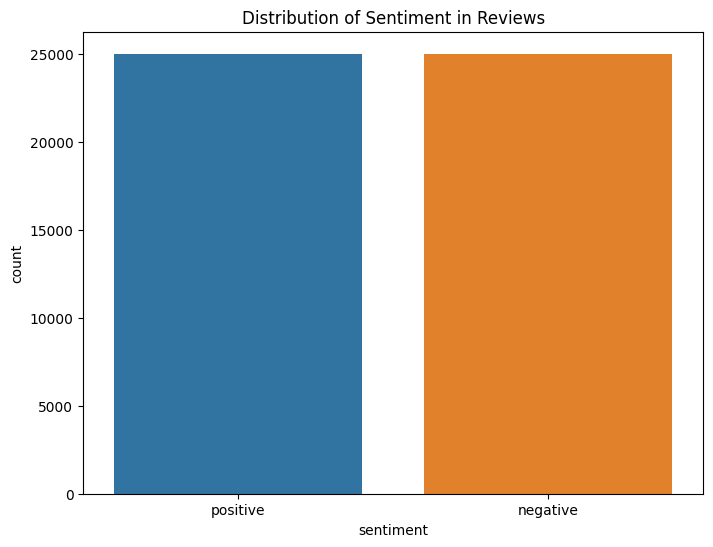

In [13]:
def perform_eda(df):
    # Review length analysis
    df['review_length'] = df['processed_review'].str.len()
    
    # Plot review length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='review_length', bins=50)
    plt.title('Distribution of Processed Review Lengths')
    plt.xlabel('Review Length')
    plt.show()
    
    # Word cloud
    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(' '.join(df['processed_review']))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word Cloud of Processed Reviews')
    plt.show()
    
    # Sentiment distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='sentiment')
    plt.title('Distribution of Sentiment in Reviews')
    plt.show()

perform_eda(df)

# 7. POS Tagging

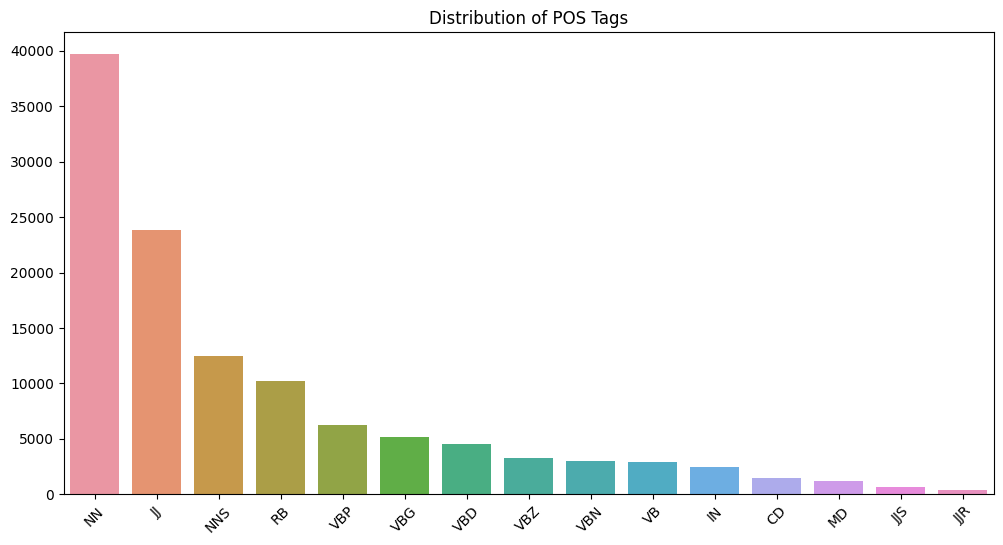

In [14]:
def analyze_pos_tags(texts, sample_size=1000):
    # Apply POS tagging to a sample
    sample_texts = texts.head(sample_size)
    pos_tags = [pos_tag(word_tokenize(text)) for text in sample_texts]
    
    # Count POS tags
    tag_counts = Counter([tag for tags in pos_tags for _, tag in tags])
    
    # Plot distribution
    plt.figure(figsize=(12, 6))
    tags, counts = zip(*tag_counts.most_common(15))
    sns.barplot(x=list(tags), y=list(counts))
    plt.xticks(rotation=45)
    plt.title('Distribution of POS Tags')
    plt.show()
    
    return pos_tags

pos_tags = analyze_pos_tags(df['processed_review'])

# 8. Word2Vec

In [15]:
def train_word2vec(texts):
    # Tokenize sentences
    sentences = [text.split() for text in texts]
    
    # Train Word2Vec model
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
    
    return model

w2v_model = train_word2vec(df['processed_review'])

# Additional visualizations

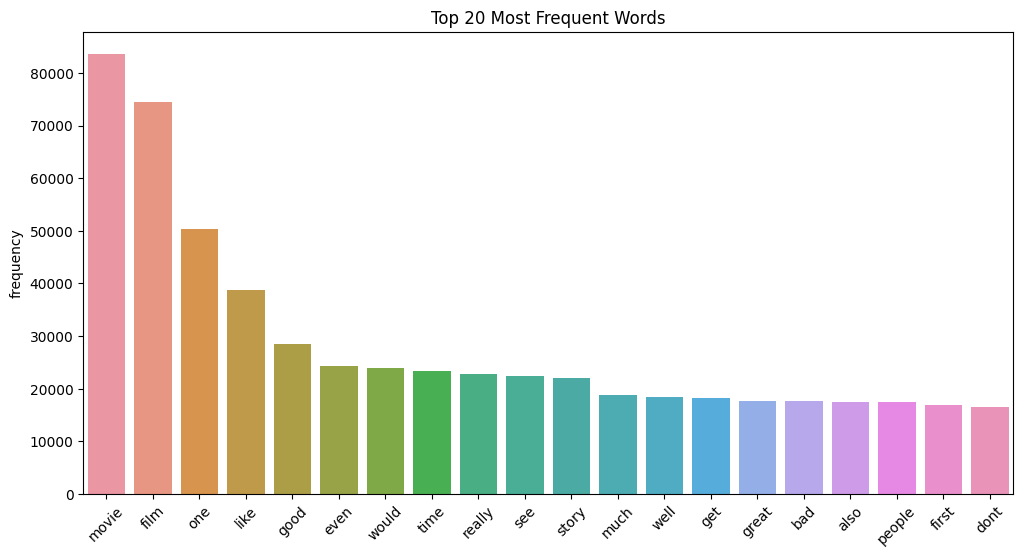

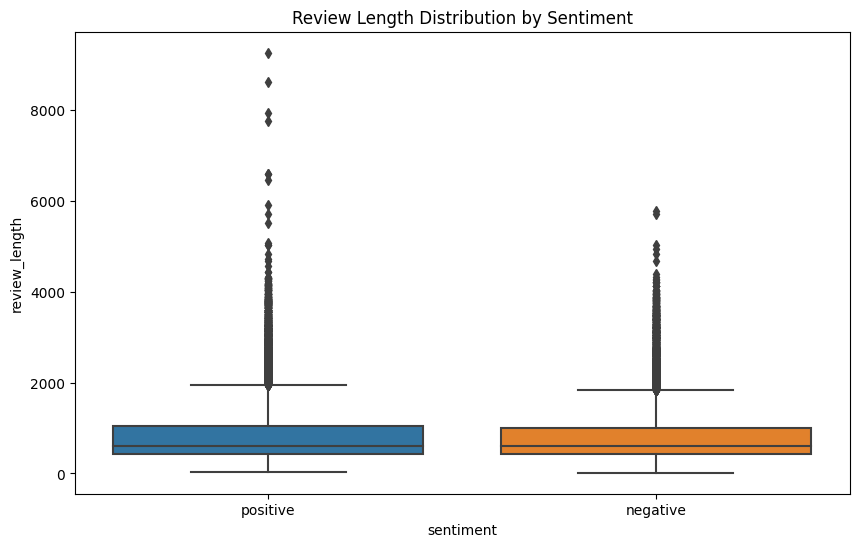

In [16]:
def plot_additional_insights(df, word_frequencies):
    # Word frequency distribution
    plt.figure(figsize=(12, 6))
    top_words = word_frequencies.head(20)
    sns.barplot(x=top_words.index, y='frequency', data=top_words)
    plt.xticks(rotation=45)
    plt.title('Top 20 Most Frequent Words')
    plt.show()
    
    # Average review length by sentiment
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='sentiment', y='review_length')
    plt.title('Review Length Distribution by Sentiment')
    plt.show()

plot_additional_insights(df, word_frequencies)